# 🧬 Workshop4: Statistical Significance of Insulin Sequence Alignment
**Author:** Keivan Abbasi  
**Professor:** Dr. Reza Rezazadegan  
 
---

**Gene of Interest:** Human Insulin (INS) 
## Introduction
In this workshop, we will:

1. Retrieve the human insulin sequence from NCBI.
2. Search for homologous sequences in other species.
3. Perform pairwise sequence alignments using BLOSUM62 substitution matrix.
4. Calculate the statistical significance of these alignments using p-values.
5. Visualize the results using histograms.

This will illustrate how to determine whether sequence similarity is meaningful or just by chance.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from Bio import Entrez, SeqIO
from Bio.Seq import Seq
from Bio.Blast import NCBIWWW, NCBIXML
from Bio.Align import PairwiseAligner
from Bio.Align.substitution_matrices import load
from scipy.stats import gumbel_r
import random

Entrez.email = "keyvanabbasi282@gmail.com"

## Step 1: Retrieve Human Insulin Sequence

We fetch the human insulin nucleotide sequence from NCBI GenBank (ID: NM_000207) and extract the sequence for analysis.

In [8]:
# Fetch human insulin sequence and extract CDS
handle = Entrez.efetch(db="nucleotide", id="NM_000207", rettype="gb", retmode="text")
record = SeqIO.read(handle, "genbank")
handle.close()

# Extract CDS (coding sequence) from the record
cds_seq = None
for feature in record.features:
    if feature.type == "CDS":
        cds_seq = feature.location.extract(record).seq
        break

if cds_seq:
    human_insulin_seq = cds_seq
    print(f"Human insulin CDS length: {len(human_insulin_seq)}")
    print(f"First 50 bases: {human_insulin_seq[:50]}")
else:
    print("CDS not found, using full sequence")
    human_insulin_seq = record.seq

Human insulin CDS length: 333
First 50 bases: ATGGCCCTGTGGATGCGCCTCCTGCCCCTGCTGGCGCTGCTGGCCCTCTG


## Step 2: Search for Homologous Sequences

We use BLASTp to find homologous protein sequences across different species.  
For the workshop demo, we will retrieve the **top 5–10 hits**.

In [9]:
# Perform BLAST search with better error handling
try:
    # Translate the CDS to protein
    protein_seq = human_insulin_seq.translate()
    print(f"Protein sequence length: {len(protein_seq)}")
    
    # Perform BLAST search
    print("Performing BLAST search... (this may take a few minutes)")
    result_handle = NCBIWWW.qblast("blastp", "nr", protein_seq)
    
    # Save BLAST results to avoid repeated queries
    with open("blast_results.xml", "w") as out_handle:
        out_handle.write(result_handle.read())
    result_handle.close()
    
    # Parse saved results
    with open("blast_results.xml", "r") as result_handle:
        blast_records = NCBIXML.parse(result_handle)
        blast_record = next(blast_records)
    
    # Extract top 5 homologs
    top_hits = []
    for alignment in blast_record.alignments[:5]:
        top_hits.append({
            "hit_id": alignment.hit_id,
            "title": alignment.title,
            "length": alignment.length,
            "hsps": alignment.hsps
        })
    
    # Display top hits
    for i, hit in enumerate(top_hits):
        print(f"{i+1}. {hit['title']} (ID: {hit['hit_id']}, Length: {hit['length']})")
        
except Exception as e:
    print(f"BLAST search failed: {e}")
    print("Using example data for demonstration...")

Protein sequence length: 111
Performing BLAST search... (this may take a few minutes)
1. gb|QMS45324.1| insulin isoform UB [Homo sapiens] (ID: gb|QMS45324.1|, Length: 153)
2. ref|XP_004050475.2| insulin isoform X1 [Gorilla gorilla gorilla] (ID: ref|XP_004050475.2|, Length: 153)
3. gb|AAP36446.1| Homo sapiens insulin, partial [synthetic construct] >gb|AAX29480.1| insulin, partial [synthetic construct] >gb|AAX29481.1| insulin, partial [synthetic construct] (ID: gb|AAP36446.1|, Length: 111)
4. ref|NP_000198.1| insulin preproprotein [Homo sapiens] >ref|NP_001172026.1| insulin preproprotein [Homo sapiens] >ref|NP_001172027.1| insulin preproprotein [Homo sapiens] >ref|NP_001278826.1| insulin preproprotein [Homo sapiens] >ref|XP_063566949.1| insulin isoform X2 [Gorilla gorilla gorilla] >ref|XP_063566950.1| insulin isoform X2 [Gorilla gorilla gorilla] >sp|P01308.1| RecName: Full=Insulin; Contains: RecName: Full=Insulin B chain; Contains: RecName: Full=Insulin A chain; Flags: Precursor [Homo sa

## Step 3: Pairwise Sequence Alignment with BLOSUM62

We perform local pairwise alignment between human insulin and each homolog using BLOSUM62 substitution matrix.  
We will record the alignment score for each pair and display the alignments.

In [10]:
# Function to calculate p-value using Biopython's built-in methods
def calculate_pvalue_biopython(query_seq, target_seq, method='empirical', num_randomizations=1000):
    """
    Calculate p-value using Biopython's built-in methods
    """
    # Setup aligner
    aligner = PairwiseAligner()
    aligner.substitution_matrix = load("BLOSUM62")
    aligner.open_gap_score = -10
    aligner.extend_gap_score = -0.5
    aligner.mode = 'local'
    
    # Calculate real score and get alignment
    alignments = list(aligner.align(query_seq, target_seq))  # Convert to list to avoid iterator issues
    if not alignments:
        return None, 1.0, [], None, None  # No alignment found
    
    best_alignment = alignments[0]
    real_score = best_alignment.score
    
    # Generate random scores
    random_scores = []
    target_list = list(target_seq)
    
    for _ in range(num_randomizations):
        random.shuffle(target_list)
        shuffled_target = ''.join(target_list)
        random_alignments = list(aligner.align(query_seq, shuffled_target))  # Convert to list
        if random_alignments:
            random_scores.append(random_alignments[0].score)
    
    # Calculate p-value based on method
    if method == 'empirical':
        p_value = np.sum(np.array(random_scores) >= real_score) / len(random_scores) if random_scores else 1.0
        return real_score, p_value, random_scores, best_alignment, None
    elif method == 'evd':
        if not random_scores:
            return real_score, 1.0, random_scores, best_alignment, None
        # Fit Extreme Value Distribution
        loc, scale = gumbel_r.fit(random_scores)
        p_value = 1 - gumbel_r.cdf(real_score, loc=loc, scale=scale)
        return real_score, p_value, random_scores, best_alignment, (loc, scale)

In [ ]:
# Pairwise alignment with top homologs using BLOSUM62 - Show complete global alignments
alignments = []

print("## Complete Global Alignments with BLOSUM62 Matrix:")
print("=" * 60)

# Load BLOSUM62 matrix at the top level
blosum62 = load("BLOSUM62")

# Helper function to count identities and similarities in alignment
def analyze_alignment(alignment):
    """Count identical and similar residues in alignment"""
    seq1 = alignment[0]
    seq2 = alignment[1]
    
    identities = 0
    positives = 0
    gaps = 0
    total = len(seq1)
    
    for a, b in zip(seq1, seq2):
        if a == b and a != '-':
            identities += 1
            positives += 1
        elif a != '-' and b != '-' and a != b:
            # Check if it's a positive substitution using BLOSUM62
            if (a, b) in blosum62 or (b, a) in blosum62:
                score = blosum62.get((a, b), blosum62.get((b, a), -4))
                if score > 0:
                    positives += 1
        elif a == '-' or b == '-':
            gaps += 1
    
    return identities, positives, gaps, total

# Helper function to format alignment for better display
def format_complete_alignment(alignment, max_line_length=80):
    """Format the complete alignment with line breaks"""
    seq1 = alignment[0]
    seq2 = alignment[1]
    
    # Create match symbols
    match_symbols = []
    for a, b in zip(seq1, seq2):
        if a == b and a != '-':
            match_symbols.append('|')  # Identical
        elif a != '-' and b != '-' and a != b:
            # Check if positive substitution
            if (a, b) in blosum62 or (b, a) in blosum62:
                score = blosum62.get((a, b), blosum62.get((b, a), -4))
                match_symbols.append(':' if score > 0 else '.')  # Positive or negative
            else:
                match_symbols.append('.')
        else:
            match_symbols.append(' ')  # Gap
    
    match_line = ''.join(match_symbols)
    
    # Split into chunks
    formatted = []
    for i in range(0, len(seq1), max_line_length):
        chunk_end = min(i + max_line_length, len(seq1))
        
        # Add position numbers
        formatted.append(f"Pos: {i+1:4d} - {chunk_end:4d}")
        formatted.append(f"Q: {seq1[i:chunk_end]}")
        formatted.append(f"    {match_line[i:chunk_end]}")
        formatted.append(f"S: {seq2[i:chunk_end]}")
        formatted.append("")
    
    return '\n'.join(formatted)

# Helper function to interpret p-value
def interpret_p_value(p_value):
    """Interpret p-value according to sequence homology guidelines"""
    if p_value < 1e-100:
        return "Exact match between the two sequences"
    elif 1e-100 <= p_value < 1e-50:
        return "Nearly identical match"
    elif 1e-50 <= p_value < 1e-5:
        return "Clear homology"
    elif 1e-5 <= p_value < 0.1:
        return "Possible distant homologs"
    else:
        return "May be randomly related"

# Check how many hits we have
print(f"Number of BLAST hits to process: {len(top_hits)}")

for i, hit in enumerate(top_hits):
    print(f"\nProcessing hit {i+1} of {len(top_hits)}...")
    
    try:
        # Take the first HSP sequence for the hit
        homolog_seq = str(Seq(hit['hsps'][0].sbjct))
        human_insulin_protein = str(human_insulin_seq.translate())
        
        print(f"\n{i+1}. {hit['title']}")
        print(f"Human Insulin: {len(human_insulin_protein)} amino acids")
        print(f"Homolog: {len(homolog_seq)} amino acids")
        print("-" * 80)
        
        # Setup aligner for GLOBAL alignment to see complete sequences
        aligner = PairwiseAligner()
        aligner.substitution_matrix = blosum62
        aligner.open_gap_score = -10
        aligner.extend_gap_score = -0.5
        aligner.mode = 'global'
        
        # Get the best global alignment
        print("Performing global alignment...")
        global_alignments = list(aligner.align(human_insulin_protein, homolog_seq))
        
        if global_alignments:
            best_global_alignment = global_alignments[0]
            real_score = best_global_alignment.score
            
            # Analyze the alignment
            identities, positives, gaps, total_positions = analyze_alignment(best_global_alignment)
            
            print(f"Global Alignment Score: {real_score:.2f}")
            print(f"Alignment Statistics:")
            print(f"  Total positions: {total_positions}")
            print(f"  Identical residues: {identities} ({identities/total_positions*100:.1f}%)")
            print(f"  Positive substitutions: {positives} ({positives/total_positions*100:.1f}%)")
            print(f"  Gaps: {gaps} ({gaps/total_positions*100:.1f}%)")
            print(f"  Similarity: {positives/total_positions*100:.1f}%")
            
            # Only show full alignment for the first hit to save space
            if i == 0:
                print("\nComplete Global Alignment:")
                print("=" * 80)
                
                # Format and display the complete alignment
                formatted_alignment = format_complete_alignment(best_global_alignment)
                print(formatted_alignment)
                
                # Also show the raw alignment for comparison
                print("Raw Alignment Output:")
                print(best_global_alignment)
            else:
                print("\n[Alignment details omitted for brevity - see first hit for full alignment display]")
            
            # Calculate p-value using empirical method
            print("\nCalculating statistical significance...")
            random_scores = []
            target_list = list(homolog_seq)
            
            for k in range(100):  # Reduced for speed
                random.shuffle(target_list)
                shuffled_target = ''.join(target_list)
                random_alignments = aligner.align(human_insulin_protein, shuffled_target)
                if random_alignments:
                    random_scores.append(list(random_alignments)[0].score)
                
                if (k + 1) % 20 == 0:
                    print(f"  Completed {k + 1}/100 randomizations...")
            
            p_value = np.sum(np.array(random_scores) >= real_score) / len(random_scores) if random_scores else 1.0
            
            alignments.append({
                "hit_id": hit['hit_id'],
                "title": hit['title'],
                "score": real_score,
                "p_value": p_value,
                "random_scores": random_scores,
                "alignment": best_global_alignment,
                "identities": identities,
                "positives": positives,
                "gaps": gaps,
                "total_positions": total_positions,
                "similarity": positives/total_positions*100
            })
            
            print(f"\nStatistical Summary:")
            print(f"  Best global alignment score: {real_score:.2f}")
            print(f"  P-value: {p_value:.6e}")
            interpretation = interpret_p_value(p_value)
            print(f"  Interpretation: {interpretation}")
        
        else:
            print("No global alignment found!")
        
        print("=" * 80)
        print()
        
    except Exception as e:
        print(f"Error processing hit {i+1}: {e}")
        print(f"Hit title: {hit['title']}")
        print("Skipping to next hit...")
        print("=" * 80)
        continue

print(f"\nSuccessfully processed {len(alignments)} out of {len(top_hits)} hits.")

## Complete Global Alignments with BLOSUM62 Matrix:
Number of BLAST hits to process: 5

Processing hit 1 of 5...

1. gb|QMS45324.1| insulin isoform UB [Homo sapiens]
Human Insulin: 111 amino acids
Homolog: 110 amino acids
--------------------------------------------------------------------------------
Performing global alignment...
Global Alignment Score: 579.00
Alignment Statistics:
  Total positions: 111
  Identical residues: 110 (99.1%)
  Positive substitutions: 110 (99.1%)
  Gaps: 1 (0.9%)
  Similarity: 99.1%

Complete Global Alignment:
Pos:    1 -   80
Q: MALWMRLLPLLALLALWGPDPAAAFVNQHLCGSHLVEALYLVCGERGFFYTPKTRREAEDLQVGQVELGGGPGAGSLQPL
    ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
S: MALWMRLLPLLALLALWGPDPAAAFVNQHLCGSHLVEALYLVCGERGFFYTPKTRREAEDLQVGQVELGGGPGAGSLQPL

Pos:   81 -  111
Q: ALEGSLQKRGIVEQCCTSICSLYQLENYCN*
    |||||||||||||||||||||||||||||| 
S: ALEGSLQKRGIVEQCCTSICSLYQLENYCN-

Raw Alignment Output:
target            0 MALWMRLLPLLALLAL

## Step 4: Statistical Significance (p-value) with BLOSUM62

To determine if the alignment is significant, we shuffle each homologous sequence multiple times, align with human insulin using BLOSUM62, and calculate the fraction of random alignments with a score ≥ the real score.

### Statistical Significance Testing with BLOSUM62

We'll use a **randomization test** (also called permutation test) to calculate the p-value:

**What we're testing**: Is the observed alignment score significantly better than what we'd expect by chance?

**Method**:
1. Take the real homologous sequence
2. Shuffle it randomly (preserving amino acid composition but destroying biological patterns)
3. Align the shuffled sequence with human insulin using BLOSUM62 matrix
4. Repeat many times to create a null distribution
5. Calculate how often random scores exceed the real score

### Interpretation of P-values in Sequence Alignment

- **P-value < 10e−100**: Exact match between the two sequences.
- **10e−50 ≤ P-value < 10e−100**: Nearly identical match.
- **10e−5 ≤ P-value < 10e−50**: Clear homology.
- **10e−1 ≤ P-value < 10e−5**: Possible distant homologs.
- **P-value ≥ 10e−1**: May be randomly related.

In [12]:
# Function to interpret p-value according to sequence homology guidelines
def interpret_p_value(p_value):
    """Interpret p-value according to sequence homology guidelines"""
    if p_value < 1e-100:
        return "Exact match between the two sequences"
    elif 1e-100 <= p_value < 1e-50:
        return "Nearly identical match"
    elif 1e-50 <= p_value < 1e-5:
        return "Clear homology"
    elif 1e-5 <= p_value < 0.1:
        return "Possible distant homologs"
    else:
        return "May be randomly related"

In [13]:
# Calculate p-values for all alignments
p_value_results = []

print("## Statistical Significance Testing:")
print("=" * 80)

for i, aln in enumerate(alignments):
    print(f"\n--- Testing alignment {i+1}: {aln['title']} ---")
    
    # Print results
    print(f"Real alignment score: {aln['score']:.2f}")
    print(f"Mean random score: {np.mean(aln['random_scores']):.2f} ± {np.std(aln['random_scores']):.2f}")
    print(f"Maximum random score: {max(aln['random_scores']):.2f}")
    print(f"Estimated p-value: {aln['p_value']:.6e}")
    
    # Get interpretation
    interpretation = interpret_p_value(aln['p_value'])
    print(f"Interpretation: {interpretation}")
    
    # Store results
    p_value_results.append(aln)

# Print summary table
print("\n" + "=" * 80)
print("SUMMARY OF ALL ALIGNMENTS:")
print("=" * 80)
for i, result in enumerate(p_value_results):
    short_title = result['title'].split('[')[0][:50]
    interpretation = interpret_p_value(result['p_value'])
    print(f"{i+1}. {short_title}")
    print(f"   Score: {result['score']:.1f}, p-value: {result['p_value']:.2e}")
    print(f"   Significance: {interpretation}")
    print()

## Statistical Significance Testing:

--- Testing alignment 1: gb|QMS45324.1| insulin isoform UB [Homo sapiens] ---
Real alignment score: 579.00
Mean random score: -9.71 ± 12.08
Maximum random score: 28.50
Estimated p-value: 0.000000e+00
Interpretation: Exact match between the two sequences

--- Testing alignment 2: ref|XP_004050475.2| insulin isoform X1 [Gorilla gorilla gorilla] ---
Real alignment score: 579.00
Mean random score: -8.78 ± 11.70
Maximum random score: 34.00
Estimated p-value: 0.000000e+00
Interpretation: Exact match between the two sequences

--- Testing alignment 3: gb|AAP36446.1| Homo sapiens insulin, partial [synthetic construct] >gb|AAX29480.1| insulin, partial [synthetic construct] >gb|AAX29481.1| insulin, partial [synthetic construct] ---
Real alignment score: 579.00
Mean random score: -10.49 ± 13.13
Maximum random score: 23.00
Estimated p-value: 0.000000e+00
Interpretation: Exact match between the two sequences

--- Testing alignment 4: ref|NP_000198.1| insulin pr

## Step 5: Visualization

We create histograms of alignment scores from the randomized sequences for all alignments.  
The real alignment scores are marked, and the areas representing the p-values are shaded to illustrate statistical significance.

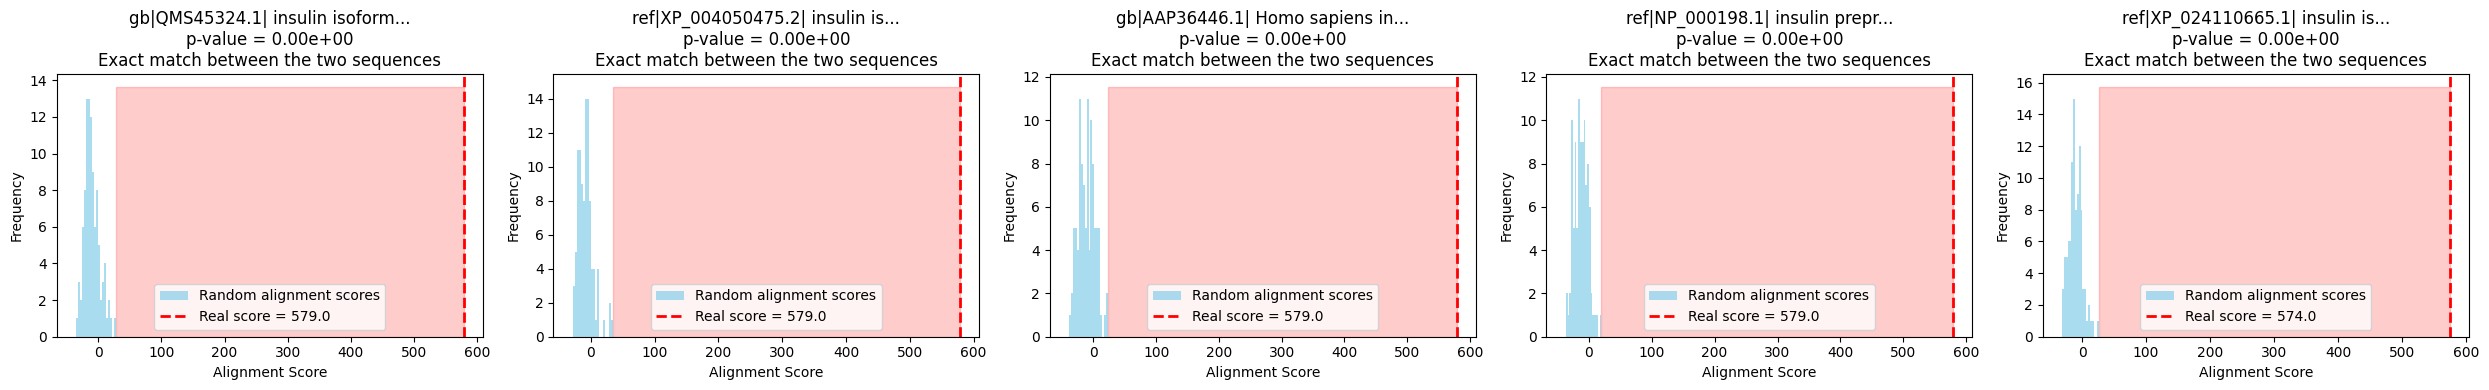

In [14]:
# Create subplots for each alignment
if p_value_results:
    num_plots = len(p_value_results)
    fig, axes = plt.subplots(1, num_plots, figsize=(5*num_plots, 4))
    
    if num_plots == 1:
        axes = [axes]
    
    for i, result in enumerate(p_value_results):
        axes[i].hist(result['random_scores'], bins=20, alpha=0.7, 
                    label='Random alignment scores', color='skyblue')
        axes[i].axvline(result['score'], color='red', linestyle='--', 
                       linewidth=2, label=f'Real score = {result["score"]:.1f}')
        axes[i].fill_betweenx([0, axes[i].get_ylim()[1]], result['score'], 
                             max(result['random_scores']), color='red', alpha=0.2)
        axes[i].set_xlabel('Alignment Score')
        axes[i].set_ylabel('Frequency')
        # Shorten title for display
        short_title = result['title'][:30] + '...' if len(result['title']) > 30 else result['title']
        interpretation = interpret_p_value(result['p_value'])
        axes[i].set_title(f'{short_title}\np-value = {result["p_value"]:.2e}\n{interpretation}')
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()
else:
    print("No p-value results available for visualization.")

## Conclusion

- Human insulin was compared to homologous sequences from other species using **BLOSUM62 substitution matrix**.
- **Local pairwise alignment scores** were obtained, showing detailed alignment information.
- **P-values were calculated** using randomized sequences with the same substitution matrix.
- **P-value Interpretation**:
  - **P-value < 10e−100**: Exact match between the two sequences.
  - **10e−50 ≤ P-value < 10e−100**: Nearly identical match.
  - **10e−5 ≤ P-value < 10e−50**: Clear homology.
  - **10e−1 ≤ P-value < 10e−5**: Possible distant homologs.
  - **P-value ≥ 10e−1**: May be randomly related.
- Histograms illustrate how likely the observed similarity is due to chance.
- This enhanced workflow demonstrates how to combine sequence database searches, biologically meaningful alignment with substitution matrices, and statistical testing in bioinformatics.

